In [2]:
%%bash
conda env list
pwd

# conda environments:
#
base                  *  /usr/local/usrapps/probioticengring/tvnguyen/conda/envs/tvnBase
tvnEnv0003_colabfold     /usr/local/usrapps/probioticengring/tvnguyen/conda/envs/tvnBase/envs/tvnEnv0003_colabfold
                         /usr/local/usrapps/probioticengring/tvnguyen/localcolabfold/colabfold-conda
                         /usr/local/usrapps/probioticengring/tvnguyen/localcolabfold/conda

/gpfs_common/share02/probioticengring/tvnguye4/google_cloud/protein_ligand/colabfold/test


# introduction
- [alphafold](https://github.com/google-deepmind/alphafold)
- [colabfold-git](https://github.com/sokrypton/ColabFold?tab=readme-ov-file)
- [colabfold-conda](https://anaconda.org/bioconda/colabfold)
- [localcolabfold](https://github.com/YoshitakaMo/localcolabfold)

# check

In [1]:
display_images = True #@param {type:"boolean"}

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2

import os
import numpy as np

# input sequence

In [2]:
test = "MALKSLVLLSLLVLVLLLVRVQPSLGKETAAAKFERQHMDSSTSAASSSNYCNQMMKSRNLTKDRCKPVNTFVHESLADVQAVCSQKNVACKNGQTNCYQSYSTMSITDCRETGSSKYPNCAYKTTQANKHIIVACEGNPYVPVHFDASV"

In [3]:
import os
import re
import hashlib
import sys

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x, y):
    return x + "_" + hashlib.sha1(y.encode()).hexdigest()[:5]

# Input your protein sequence here
query_sequence = test
# Use `:` to specify inter-protein chainbreaks for modeling complexes (supports homo- and hetero-oligomers). For example, "PI...SK:PI...SK" for a homodimer
jobname = 'test'  # Name of your job
num_relax = 0  # Number of models to use (0, 1, 5)
template_mode = "none"  # Template mode ("none", "pdb100", "custom")

use_amber = num_relax > 0

# Remove whitespaces
query_sequence = "".join(query_sequence.split())

basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)

# Function to check if a directory exists
def check(folder):
    return not os.path.exists(folder)

# Check if directory with jobname exists, create a new directory if it does not
if not check(jobname):
    n = 0
    while not check(f"{jobname}_{n}"):
        n += 1
    jobname = f"{jobname}_{n}"

# Make directory to save results
os.makedirs(jobname, exist_ok=True)

# Save queries
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
    text_file.write(f"id,sequence\n{jobname},{query_sequence}")

use_templates = False
custom_template_path = None

if template_mode == "pdb100":
    use_templates = True
    # Here, you would need to implement your logic to search for templates in pdb100.
elif template_mode == "custom":
    custom_template_path = os.path.join(jobname, "template")
    os.makedirs(custom_template_path, exist_ok=True)
    # Implement your custom template handling logic here, such as prompting the user to place template files in the specified directory.
    use_templates = True
else:
    custom_template_path = None
    use_templates = False

print("jobname:", jobname)
print("sequence:", query_sequence)
print("length:", len(query_sequence.replace(":", "")))

jobname: test_89f1c
sequence: MALKSLVLLSLLVLVLLLVRVQPSLGKETAAAKFERQHMDSSTSAASSSNYCNQMMKSRNLTKDRCKPVNTFVHESLADVQAVCSQKNVACKNGQTNCYQSYSTMSITDCRETGSSKYPNCAYKTTQANKHIIVACEGNPYVPVHFDASV
length: 150


# msa option

In [4]:
import os
import sys

msa_mode = "mmseqs2_uniref_env"  # Options: "mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"
pair_mode = "unpaired_paired"  # Options: "unpaired_paired", "paired", "unpaired"

# Decide which a3m to use
if "mmseqs2" in msa_mode:
    a3m_file = os.path.join(jobname, f"{jobname}.a3m")

elif msa_mode == "custom":
    # For custom MSA, prompt user to specify the file path
    custom_msa_path = input("Enter the path to your custom MSA file: ")
    a3m_file = os.path.join(jobname, f"{jobname}.custom.a3m")
    
    if not os.path.isfile(custom_msa_path):
        print(f"File not found: {custom_msa_path}")
        sys.exit(1)
    
    # Process the custom MSA file if necessary
    # Assuming the file needs to be copied or moved to the job directory
    os.rename(custom_msa_path, a3m_file)
    print(f"Custom MSA file moved to: {a3m_file}")

else:
    # For single sequence mode, create an a3m file with the query sequence
    a3m_file = os.path.join(jobname, f"{jobname}.single_sequence.a3m")
    with open(a3m_file, "w") as text_file:
        text_file.write(f">1\n{query_sequence}")

# Additional logic here based on the mode and further processing

print(f"MSA file prepared at: {a3m_file}")

MSA file prepared at: test_89f1c/test_89f1c.a3m


# advanced option

In [6]:
# Advanced settings
model_type = "auto"  # Options: "auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3", "deepfold_v1"
num_recycles = "3"  # Options: "auto", "0", "1", "3", "6", "12", "24", "48"
recycle_early_stop_tolerance = "auto"  # Options: "auto", "0.0", "0.5", "1.0"
relax_max_iterations = 200  # Options: 0, 200, 2000
pairing_strategy = "greedy"  # Options: "greedy", "complete"
max_msa = "auto"  # Options: "auto", specific limits like "512:1024"
num_seeds = 1  # Options: 1, 2, 4, 8, 16
use_dropout = False  # Options: True, False
save_all = False  # Options: True, False
save_recycles = False  # Options: True, False
dpi = 200  # Image resolution for output

# Parse and set the options based on the user input
num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto":
    max_msa = None

# Handle model type and recycles based on user selection
if model_type == "auto":
    model_type = "alphafold2_ptm" if query_sequence.count(":") == 0 else "alphafold2_multimer_v3"
    num_recycles = 20 if model_type == "alphafold2_multimer_v3" else 3
    recycle_early_stop_tolerance = 0.5 if model_type == "alphafold2_multimer_v3" else 0.0

# Print the settings for confirmation
print(f"Model type: {model_type}")
print(f"Number of recycles: {num_recycles}")
print(f"Recycle early stop tolerance: {recycle_early_stop_tolerance}")
print(f"Relax max iterations: {relax_max_iterations}")
print(f"Pairing strategy: {pairing_strategy}")
print(f"Max MSA settings: {max_msa}")
print(f"Number of seeds: {num_seeds}")
print(f"Use dropout: {use_dropout}")
print(f"Save all intermediate results: {save_all}")
print(f"Save recycles: {save_recycles}")
print(f"DPI for image resolution: {dpi}")

# Replace Google Drive saving functionality with local file saving
if save_all or save_recycles:
    # Implement local saving logic here
    print("Note: Saving functionality needs to be implemented for local environment.")


Model type: alphafold2_ptm
Number of recycles: 3
Recycle early stop tolerance: 0.0
Relax max iterations: 200
Pairing strategy: greedy
Max MSA settings: None
Number of seeds: 1
Use dropout: False
Save all intermediate results: False
Save recycles: False
DPI for image resolution: 200


# Run Prediction

2024-03-31 14:56:38,473 Unable to initialize backend 'cuda': 
2024-03-31 14:56:38,477 Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-03-31 14:56:38,481 Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2024-03-31 14:56:38,492 WARNING: no GPU detected, will be using CPU
2024-03-31 14:56:46,985 Found 6 citations for tools or databases
2024-03-31 14:56:46,986 Query 1/1: test_bf18f (length 10)


COMPLETE: 100%|████████████████████████████████████████████████████████████████████████| 150/150 [elapsed: 00:01 remaining: 00:00]


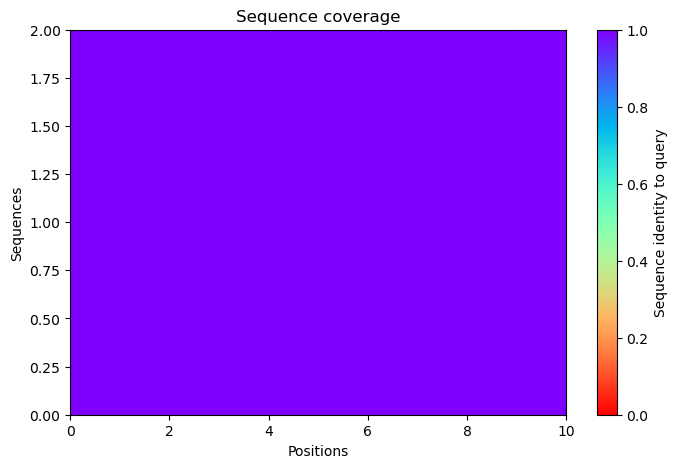

2024-03-31 14:56:49,764 Setting max_seq=2, max_extra_seq=1
2024-03-31 14:57:27,666 Could not predict test_bf18f. Not Enough GPU memory? INVALID_ARGUMENT: Symbol main.8263 not found.
2024-03-31 14:57:27,666 Done
  adding: test_bf18f/ (stored 0%)
  adding: test_bf18f/test_bf18f_env/ (stored 0%)
  adding: test_bf18f/test_bf18f_env/bfd.mgnify30.metaeuk30.smag30.a3m (stored 0%)
  adding: test_bf18f/test_bf18f_env/out.tar.gz (stored 0%)
  adding: test_bf18f/test_bf18f_env/uniref.a3m (stored 0%)
  adding: test_bf18f/test_bf18f_env/pdb70.m8 (stored 0%)
  adding: test_bf18f/test_bf18f_env/msa.sh (deflated 74%)
  adding: test_bf18f/test_bf18f.a3m (deflated 32%)
  adding: test_bf18f/test_bf18f.csv (stored 0%)
  adding: test_bf18f/cite.bibtex (deflated 52%)
  adding: test_bf18f/test_bf18f_coverage.png (deflated 21%)
  adding: test_bf18f/config.json (deflated 56%)
  adding: test_bf18f/log.txt (deflated 45%)


2024-03-31 14:57:27.597176: E external/xla/xla/service/cpu/simple_orc_jit.cc:423] Unable to resolve runtime symbol: `__extendhfsf2'. Hint: if the symbol a custom call target, make sure you've registered it with the JIT using XLA_CPU_REGISTER_CUSTOM_CALL_TARGET.
JIT session error: Symbols not found: [ __extendhfsf2 ]


0

In [7]:
display_images = True #@param {type:"boolean"}

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2

import os
import numpy as np
try:
  K80_chk = os.popen('srun -p gpu nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

# For some reason we need that to get pdbfixer to import
if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

def input_features_callback(input_features):
  if display_images:
    plot_msa_v2(input_features)
    plt.show()
    plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
setup_logging(Path(log_filename))

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True

download_alphafold_params(model_type, Path("."))
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    relax_max_iterations=relax_max_iterations,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1,2,3,4,5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
    user_agent="colabfold/google-colab-main",
)
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")

# display 3d structure

In [8]:
#@title Display 3D structure {run: "auto"}
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list
rank_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

tag = results["rank"][0][rank_num - 1]
jobname_prefix = ".custom" if msa_mode == "custom" else ""
pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
pdb_file = glob.glob(pdb_filename)

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

show_pdb(rank_num, show_sidechains, show_mainchains, color).show()
if color == "lDDT":
  plot_plddt_legend().show()

IndexError: list index out of range

# plots

In [ ]:
#@title Plots {run: "auto"}
from IPython.display import display, HTML
import base64
from html import escape

# see: https://stackoverflow.com/a/53688522
def image_to_data_url(filename):
  ext = filename.split('.')[-1]
  prefix = f'data:image/{ext};base64,'
  with open(filename, 'rb') as f:
    img = f.read()
  return prefix + base64.b64encode(img).decode('utf-8')

pae = ""
pae_file = os.path.join(jobname,f"{jobname}{jobname_prefix}_pae.png")
if os.path.isfile(pae_file):
    pae = image_to_data_url(pae_file)
cov = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_coverage.png"))
plddt = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_plddt.png"))